# Tutorial on Hand Written Digit Recognition

In this tutorial we will go through the basic use case of MXNet and also touch on some advanced usages. This example is based on the MNIST dataset, which contains 70,000 images of hand written characters with 28-by-28 pixel size.

This tutorial covers the following topics:
- network definition.
- Variable naming.
- Basic data loading and training with feed-forward deep neural networks.
- Monitoring intermediate outputs for debuging.
- Custom training loop for advanced models.

First let's import the modules and setup logging:

In [9]:
%matplotlib inline
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import skimage

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
print('test my test')

test
more test


## Network Definition
Now we can start constructing our network:

In [10]:
# Variables are place holders for input arrays. We give each variable a unique name.
data = mx.symbol.Variable('data')

# The input is fed to a fully connected layer that computes Y=WX+b.
# This is the main computation module in the network.
# Each layer also needs an unique name. We'll talk more about naming in the next section.
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
# Activation layers apply a non-linear function on the previous layer's output.
# Here we use Rectified Linear Unit (ReLU) that computes Y = max(X, 0).
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")

fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

We can visualize the network we just defined with MXNet's visualization module:

In [11]:
mx.viz.plot_network(mlp)

ImportError: Draw network requires graphviz library

## Variable Naming

MXNet requires variable names to follow certain conventions:
- All input arrays have a name. This includes inputs (data & label) and model parameters (weight, bias, etc).
- Arrays can be renamed by creating named variable. Otherwise, a default name is given as 'SymbolName_ArrayName'. For example, FullyConnected symbol fc1's weight array is named as 'fc1_weight'.
- Although you can also rename weight arrays with variables, weight array's name should always end with '_weight' and bias array '_bias'. MXNet relies on the suffixes of array names to correctly initialize & update them.

Call list_arguments method on a symbol to get the names of all its inputs:

In [12]:
mlp.list_arguments()

['data',
 'fc1_weight',
 'fc1_bias',
 'fc2_weight',
 'fc2_bias',
 'fc3_weight',
 'fc3_bias',
 'softmax_label']

## Data Loading

We fetch and load the MNIST dataset and partition it into two sets: 60000 examples for training and 10000 examples for testing. We also visualize a few examples to get an idea of what the dataset looks like.

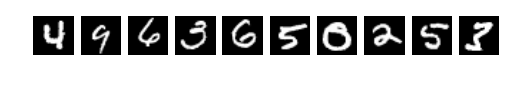

In [13]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]

Now we can create data iterators from our MNIST data. A data iterator returns a batch of data examples each time for the network to process. MXNet provide a suite of basic DataIters for parsing different data format. Here we use NDArrayIter, which wraps around a numpy array and each time slice a chunk from it along the first dimension.

In [14]:
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

In [15]:
#mx.mod.Module.forward?

## Training

With the network and data source defined, we can finally start to train our model. We do this with MXNet's convenience wrapper for feed forward neural networks (it can also be made to handle RNNs with explicit unrolling). 

In [16]:
model = mx.mod.Module(symbol=mlp, 
                    context=mx.cpu(0),
                    data_names=['data'], 
                    label_names=['softmax_label'])

model.fit(train_iter, 
        eval_data=test_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1,'momentum':0.9,'wd':0.00001},
        eval_metric='acc',
        num_epoch=10)

INFO:root:Epoch[0] Train-accuracy=0.763517
INFO:root:Epoch[0] Time cost=0.661
INFO:root:Epoch[0] Validation-accuracy=0.950100
INFO:root:Epoch[1] Train-accuracy=0.959017
INFO:root:Epoch[1] Time cost=0.822
INFO:root:Epoch[1] Validation-accuracy=0.964100
INFO:root:Epoch[2] Train-accuracy=0.971400
INFO:root:Epoch[2] Time cost=0.664
INFO:root:Epoch[2] Validation-accuracy=0.963300
INFO:root:Epoch[3] Train-accuracy=0.977667
INFO:root:Epoch[3] Time cost=0.687
INFO:root:Epoch[3] Validation-accuracy=0.970300
INFO:root:Epoch[4] Train-accuracy=0.982200
INFO:root:Epoch[4] Time cost=0.708
INFO:root:Epoch[4] Validation-accuracy=0.970600
INFO:root:Epoch[5] Train-accuracy=0.984050
INFO:root:Epoch[5] Time cost=0.637
INFO:root:Epoch[5] Validation-accuracy=0.968800
INFO:root:Epoch[6] Train-accuracy=0.986100
INFO:root:Epoch[6] Time cost=0.632
INFO:root:Epoch[6] Validation-accuracy=0.964800
INFO:root:Epoch[7] Train-accuracy=0.985817
INFO:root:Epoch[7] Time cost=0.637
INFO:root:Epoch[7] Validation-accuracy=0

## Evaluation

After the model is trained, we can evaluate it on a held out test set.
First, lets classity a sample image:

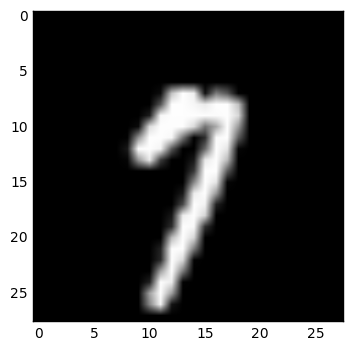

Result: 7


In [17]:
plt.imshow((X_test[0].reshape((28,28))*255).astype(np.uint8), cmap='Greys_r')
plt.show()
prediction_prob = model.predict(eval_data=test_iter,num_batch=1)
clss_pred = prediction_prob[0].asnumpy()
print('Result: {}'.format(clss_pred.argmax()),)

We can also evaluate the model's accuracy on the entire test set:

In [18]:
model.score(test_iter,eval_metric=['acc'],num_batch=1,)
#print('Accuracy:', model.score(test_iter,eval_metric='acc')*100, '%')

Now, try if your model recognizes your own hand writing.

Write a digit from 0 to 9 in the box below. Try to put your digit in the middle of the box.

##### run hand drawing test
from IPython.display import HTML

def classify(img):
    img = img[len('data:image/png;base64,'):].decode('base64')
    img = np.fromstring(img, np.uint8)
    img = skimage.transform.resize(img[:,:,3], (28,28))
    img = img.astype(np.float32).reshape((1, 784))/255.0
    return model.predict(img)[0].argmax()

html = """<style type="text/css">canvas { border: 1px solid black; }</style><div id="board"><canvas id="myCanvas" width="100px" height="100px">Sorry, your browser doesn't support canvas technology.</canvas><p><button id="classify" onclick="classify()">Classify</button><button id="clear" onclick="myClear()">Clear</button>Result: <input type="text" id="result_output" size="5" value=""></p></div>"""
script = """<script type="text/JavaScript" src="https://ajax.googleapis.com/ajax/libs/jquery/1.4.2/jquery.min.js?ver=1.4.2"></script><script type="text/javascript">function init() {var myCanvas = document.getElementById("myCanvas");var curColor = $('#selectColor option:selected').val();if(myCanvas){var isDown = false;var ctx = myCanvas.getContext("2d");var canvasX, canvasY;ctx.lineWidth = 8;$(myCanvas).mousedown(function(e){isDown = true;ctx.beginPath();var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.moveTo(canvasX, canvasY);}).mousemove(function(e){if(isDown != false) {var parentOffset = $(this).parent().offset(); canvasX = e.pageX - parentOffset.left;canvasY = e.pageY - parentOffset.top;ctx.lineTo(canvasX, canvasY);ctx.strokeStyle = curColor;ctx.stroke();}}).mouseup(function(e){isDown = false;ctx.closePath();});}$('#selectColor').change(function () {curColor = $('#selectColor option:selected').val();});}init();function handle_output(out) {document.getElementById("result_output").value = out.content.data["text/plain"];}function classify() {var kernel = IPython.notebook.kernel;var myCanvas = document.getElementById("myCanvas");data = myCanvas.toDataURL('image/png');document.getElementById("result_output").value = "";kernel.execute("classify('" + data +"')",  { 'iopub' : {'output' : handle_output}}, {silent:false});}function myClear() {var myCanvas = document.getElementById("myCanvas");myCanvas.getContext("2d").clearRect(0, 0, myCanvas.width, myCanvas.height);}</script>"""
HTML(html+script)

## Debugging

DNNs can perform poorly for a lot of reasons, like learning rate too big/small, initialization too big/small, network structure not reasonable, etc. When this happens it's often helpful to print out the weights and intermediate outputs to understand what's going on. MXNet provides a monitor utility that does this:

In [23]:
def norm_stat(d):
    """The statistics you want to see.
    We compute the L2 norm here but you can change it to anything you like."""
    return mx.nd.norm(d)/np.sqrt(d.size)

mon = mx.mon.Monitor(
    100,                 # Print every 100 batches
    norm_stat,           # The statistics function defined above
    pattern='.*weight',  # A regular expression. Only arrays with name matching this pattern will be included.
    sort=True)           # Sort output by name

model = mx.mod.Module(symbol=mlp, 
                    context=mx.cpu(0),
                    data_names=['data'], 
                    label_names=['softmax_label'])

model.fit(train_iter,
        eval_data=test_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1,'momentum':0.9,'wd':0.00001},
        eval_metric='acc',monitor= mon,
        num_epoch=1,batch_end_callback= mx.callback.Speedometer(100, 100))


INFO:root:Batch:       1 fc1_backward_weight            0.000537876	
INFO:root:Batch:       1 fc1_weight                     0.00578438	
INFO:root:Batch:       1 fc2_backward_weight            0.00179127	
INFO:root:Batch:       1 fc2_weight                     0.00575576	
INFO:root:Batch:       1 fc3_backward_weight            0.00614964	
INFO:root:Batch:       1 fc3_weight                     0.0056244	
INFO:root:Batch:     101 fc1_backward_weight            0.119085	
INFO:root:Batch:     101 fc1_weight                     0.0083836	
INFO:root:Batch:     101 fc2_backward_weight            0.256395	
INFO:root:Batch:     101 fc2_weight                     0.0219938	
INFO:root:Batch:     101 fc3_backward_weight            1.31856	
INFO:root:Batch:     101 fc3_weight                     0.0807175	
INFO:root:Epoch[0] Batch [100]	Speed: 44609.62 samples/sec	Train-accuracy=0.148020
INFO:root:Batch:     201 fc1_backward_weight            0.177065	
INFO:root:Batch:     201 fc1_weight          

## Under the hood: Custom Training Loop

`mx.model.FeedForward` is a convenience wrapper for training standard feed forward networks. What if the model you are working with is more complicated? With MXNet, you can easily control every aspect of training by writing your own training loop.

Neural network training typically has 3 steps: forward, backward (gradient), and update. With custom training loop, you can control the details in each step as while as insert complicated computations in between. You can also connect multiple networks together.

In [38]:
#mx.init.InitDesc('Unifiorm',attrs={'scale':0.01})
# mx.init.Uniform?

In [40]:
# ==================Binding=====================
# The symbol we created is only a graph description.
# To run it, we first need to allocate memory and create an executor by 'binding' it.
# In order to bind a symbol, we need at least two pieces of information: context and input shapes.
# Context specifies which device the executor runs on, e.g. cpu, GPU0, GPU1, etc.
# Input shapes define the executor's input array dimensions.
# MXNet then run automatic shape inference to determine the dimensions of intermediate and output arrays.

# data iterators defines shapes of its output with provide_data and provide_label property.
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)
# We use simple_bind to let MXNet allocate memory for us.
# You can also allocate memory youself and use bind to pass it to MXNet.
exe = mlp.simple_bind(ctx=mx.cpu(0), **input_shapes)

# ===============Initialization=================
# First we get handle to input arrays
arg_arrays = dict(zip(mlp.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(mx.init.InitDesc(name), arr)
    
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=0.1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size)
updater = mx.optimizer.get_updater(opt)

# Finally we need a metric to print out training progress
metric = mx.metric.Accuracy()

# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print ('epoch:', epoch, 'iter:', t, 'metric:', metric.get())


input_shapes {'softmax_label': (100,), 'data': (100, 784)}
epoch: 0 iter: 100 metric: ('accuracy', 0.16109999999999999)
epoch: 0 iter: 200 metric: ('accuracy', 0.45810000000000001)
epoch: 0 iter: 300 metric: ('accuracy', 0.60499999999999998)
epoch: 0 iter: 400 metric: ('accuracy', 0.68577500000000002)
epoch: 0 iter: 500 metric: ('accuracy', 0.73658000000000001)
epoch: 0 iter: 600 metric: ('accuracy', 0.77224999999999999)
epoch: 1 iter: 100 metric: ('accuracy', 0.94830000000000003)
epoch: 1 iter: 200 metric: ('accuracy', 0.95065)
epoch: 1 iter: 300 metric: ('accuracy', 0.95383333333333331)
epoch: 1 iter: 400 metric: ('accuracy', 0.95540000000000003)
epoch: 1 iter: 500 metric: ('accuracy', 0.95745999999999998)
epoch: 1 iter: 600 metric: ('accuracy', 0.95913333333333328)
epoch: 2 iter: 100 metric: ('accuracy', 0.96740000000000004)
epoch: 2 iter: 200 metric: ('accuracy', 0.96599999999999997)
epoch: 2 iter: 300 metric: ('accuracy', 0.96826666666666672)
epoch: 2 iter: 400 metric: ('accuracy'

## New Operators

MXNet provides a repository of common operators (or layers). However, new models often require new layers. There are several ways to [create new operators](https://mxnet.readthedocs.org/en/latest/tutorial/new_op_howto.html) with MXNet. Here we talk about the easiest way: pure python. 

In [42]:
# Define custom softmax operator
class NumpySoftmax(mx.operator.NumpyOp):
    def __init__(self):
        # Call the parent class constructor. 
        # Because NumpySoftmax is a loss layer, it doesn't need gradient input from layers above.
        super(NumpySoftmax, self).__init__(need_top_grad=False)
    
    def list_arguments(self):
        # Define the input to NumpySoftmax.
        return ['data', 'label']

    def list_outputs(self):
        # Define the output.
        return ['output']

    def infer_shape(self, in_shape):
        # Calculate the dimensions of the output (and missing inputs) from (some) input shapes.
        data_shape = in_shape[0]  # shape of first argument 'data'
        label_shape = (in_shape[0][0],)  # 'label' should be one dimensional and has batch_size instances.
        output_shape = in_shape[0] # 'output' dimension is the same as the input.
        return [data_shape, label_shape], [output_shape]

    def forward(self, in_data, out_data):
        x = in_data[0]  # 'data'
        y = out_data[0]  # 'output'
        
        # Compute softmax
        y[:] = np.exp(x - x.max(axis=1).reshape((x.shape[0], 1)))
        y /= y.sum(axis=1).reshape((x.shape[0], 1))

    def backward(self, out_grad, in_data, out_data, in_grad):
        l = in_data[1]  # 'label'
        l = l.reshape((l.size,)).astype(np.int)  # cast to int
        y = out_data[0]  # 'output'
        dx = in_grad[0]  # gradient for 'data'
        
        # Compute gradient
        dx[:] = y
        dx[np.arange(l.shape[0]), l] -= 1.0

numpy_softmax = NumpySoftmax()

data = mx.symbol.Variable('data')
fc1 = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2 = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3 = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Use the new operator we just defined instead of the standard softmax operator.
mlp = numpy_softmax(data=fc3, name = 'softmax')

model = mx.mod.Module(symbol=mlp, 
                    context=mx.cpu(0),
                    data_names=['data'], 
                    label_names=['softmax_label'])

model.fit(train_iter,
        eval_data=test_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1,'momentum':0.9,'wd':0.00001},
        eval_metric='acc',monitor= mon,
        num_epoch=2,batch_end_callback= mx.callback.Speedometer(100, 100))

INFO:root:Batch:     601 fc1_backward_weight            0.000536867	
INFO:root:Batch:     601 fc1_weight                     0.0416182	
INFO:root:Batch:     601 fc1_weight                     0.00576789	
INFO:root:Batch:     601 fc2_backward_weight            0.00176279	
INFO:root:Batch:     601 fc2_weight                     0.078975	
INFO:root:Batch:     601 fc2_weight                     0.00578701	
INFO:root:Batch:     601 fc3_backward_weight            0.00655569	
INFO:root:Batch:     601 fc3_weight                     0.25892	
INFO:root:Batch:     601 fc3_weight                     0.00564812	
INFO:root:Batch:     701 fc1_backward_weight            0.129655	
INFO:root:Batch:     701 fc1_weight                     0.0416182	
INFO:root:Batch:     701 fc1_weight                     0.00843231	
INFO:root:Batch:     701 fc2_backward_weight            0.308369	
INFO:root:Batch:     701 fc2_weight                     0.078975	
INFO:root:Batch:     701 fc2_weight                     0.02

## Further Readings

- More state-of-the-art cnn models are available at [mxnet/example/image-classification](https://github.com/dmlc/mxnet/tree/master/example/image-classification)